In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

print("Setup complete!")

2024-02-22 18:22:38.895300: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-22 18:22:38.895434: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-22 18:22:39.069994: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Setup complete!


## Loading data

In [2]:
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")

train_df.head()
# test_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
features = train_df.copy()
labels = features.pop('Survived')

# Remove Cabin column
features.pop('Cabin')
features.pop('Embarked')

features.Age.fillna(value=0, inplace=True)

labels.head()

/tmp/ipykernel_18/3427907163.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  features.Age.fillna(value=0, inplace=True)


0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

## Preparing dataset

Implementing preprocessing logic using Keras functional API

In [4]:
inputs = {name: tf.keras.Input(shape=(1,), name=name, dtype=(tf.string if column.dtype == 'object' else tf.float32))
          for name, column in features.items()}

inputs

{'PassengerId': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'PassengerId')>,
 'Pclass': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Pclass')>,
 'Name': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Name')>,
 'Sex': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Sex')>,
 'Age': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Age')>,
 'SibSp': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'SibSp')>,
 'Parch': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Parch')>,
 'Ticket': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Ticket')>,
 'Fare': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Fare')>}

In [5]:
numeric_inputs = {name:input for name, input in inputs.items() if input.dtype == tf.float32}

# numeric_inputs
x = layers.Concatenate()(list(numeric_inputs.values()))
norm = layers.Normalization()
norm.adapt(np.array(train_df[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

all_numeric_inputs

<KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'normalization')>

In [6]:
preprocessed_inputs = [all_numeric_inputs]

In [7]:
for name, input in inputs.items():
    if input.dtype == tf.float32:
        continue
        
    lookup = layers.StringLookup(vocabulary=np.unique(features[name]))
    one_hot = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())
    
    x = lookup(input)
    x = one_hot(x)
    preprocessed_inputs.append(x)



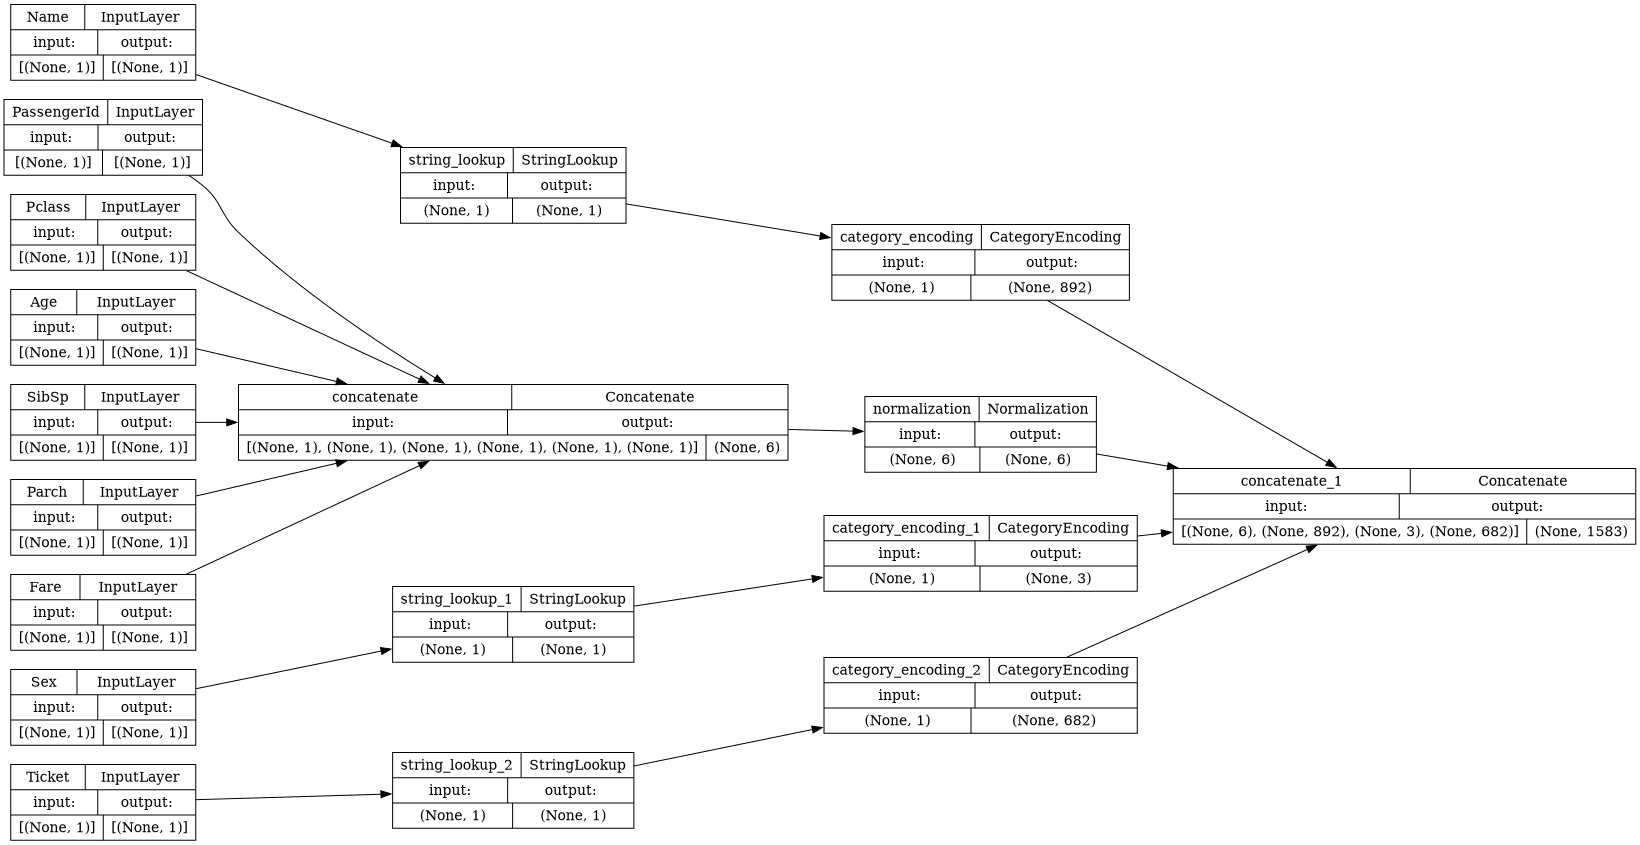

In [8]:
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)

preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

tf.keras.utils.plot_model(model = preprocessing, rankdir="LR", dpi=72, show_shapes=True)

In [9]:
features_dict = {name:np.array(value) for name, value in features.items()}

# features_dict

In [10]:
def titanic_model(preprocessing_head, inputs):
    body = tf.keras.Sequential([
        layers.Dense(64),
        layers.Dense(1)
    ])
    
    preprocessed_inputs = preprocessing_head(inputs)
    result = body(preprocessed_inputs)
    model = tf.keras.Model(inputs, result)
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                 optimizer=tf.keras.optimizers.Adam())
    return model

titanic_model = titanic_model(preprocessing, inputs)


In [11]:
titanic_model.fit(x=features_dict, y=labels, epochs=20)

Epoch 1/20
28/28 [==============================] - 1s 4ms/step - loss: nan
Epoch 2/20
28/28 [==============================] - 0s 4ms/step - loss: nan
Epoch 3/20
28/28 [==============================] - 0s 4ms/step - loss: nan
Epoch 4/20
28/28 [==============================] - 0s 4ms/step - loss: nan
Epoch 5/20
28/28 [==============================] - 0s 4ms/step - loss: nan
Epoch 6/20
28/28 [==============================] - 0s 4ms/step - loss: nan
Epoch 7/20
28/28 [==============================] - 0s 4ms/step - loss: nan
Epoch 8/20
28/28 [==============================] - 0s 4ms/step - loss: nan
Epoch 9/20
28/28 [==============================] - 0s 4ms/step - loss: nan
Epoch 10/20
28/28 [==============================] - 0s 4ms/step - loss: nan
Epoch 11/20
28/28 [==============================] - 0s 4ms/step - loss: nan
Epoch 12/20
28/28 [==============================] - 0s 4ms/step - loss: nan
Epoch 13/20
28/28 [==============================] - 0s 4ms/step - loss: nan
Epoch 14